In [1]:
import logging
import os
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel(logging.ERROR)
from skimage import img_as_ubyte
from keras.utils import img_to_array, load_img
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
from skimage.transform import resize
# Define the paths to the folders and the weights file
from IPython.display import Image as imgdisp, display
from keras.models import load_model
import tensorflow as tf
from clear_folder import clear_folder
import keras
effected_folder = '/home/abidhasan/Documents/Indicate_FH/data/effected'
not_effected_folder = '/home/abidhasan/Documents/Indicate_FH/data/not_effected'

# Image Size
size = 299
n_channels = 3

# Function to preprocess images
affected_img1 = "/home/abidhasan/Documents/Indicate_FH/train_val_test/test/effected/001_CLE204_Baseline_111.png"
affected_img2 = "/home/abidhasan/Documents/Indicate_FH/data/effected/001_CLE114_Baseline_112.png"
affected_img3 = "/home/abidhasan/Documents/Indicate_FH/data/effected/007_CLE203_Weizen_114.png"
affected_img4 = "/home/abidhasan/Documents/Indicate_FH/data/effected/CLE101_Baseline_Reaktion_CLE101_Baseline_Reaktion_3.png"
non_affected_img = "/home/abidhasan/Documents/Indicate_FH/train_val_test/test/not_effected/001_CLE197_Baseline_4.png"

2024-06-07 14:02:48.019769: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-07 14:02:48.040405: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-07 14:02:48.381816: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


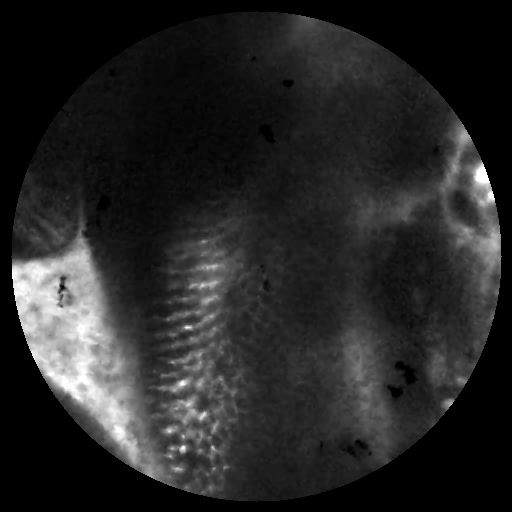

In [2]:
display(imgdisp(affected_img1))

In [3]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(
            last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [4]:
model = load_model('/home/abidhasan/Documents/Indicate_FH/saved_model/inception_100.h5')

last_conv_layer_name = "mixed10"

# Remove last layer's softmax
model.layers[-1].activation = None

2024-06-07 14:03:54.801231: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-07 14:03:54.813700: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-07 14:03:54.813809: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [5]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(
            last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [6]:
img_array = get_img_array(affected_img1, size=(size, size))

In [7]:
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

ValueError: No such layer: mixed10. Existing layers are: ['input_2', 'Conv1', 'bn_Conv1', 'Conv1_relu', 'expanded_conv_depthwise', 'expanded_conv_depthwise_BN', 'expanded_conv_depthwise_relu', 'expanded_conv_project', 'expanded_conv_project_BN', 'block_1_expand', 'block_1_expand_BN', 'block_1_expand_relu', 'block_1_pad', 'block_1_depthwise', 'block_1_depthwise_BN', 'block_1_depthwise_relu', 'block_1_project', 'block_1_project_BN', 'block_2_expand', 'block_2_expand_BN', 'block_2_expand_relu', 'block_2_depthwise', 'block_2_depthwise_BN', 'block_2_depthwise_relu', 'block_2_project', 'block_2_project_BN', 'block_2_add', 'block_3_expand', 'block_3_expand_BN', 'block_3_expand_relu', 'block_3_pad', 'block_3_depthwise', 'block_3_depthwise_BN', 'block_3_depthwise_relu', 'block_3_project', 'block_3_project_BN', 'block_4_expand', 'block_4_expand_BN', 'block_4_expand_relu', 'block_4_depthwise', 'block_4_depthwise_BN', 'block_4_depthwise_relu', 'block_4_project', 'block_4_project_BN', 'block_4_add', 'block_5_expand', 'block_5_expand_BN', 'block_5_expand_relu', 'block_5_depthwise', 'block_5_depthwise_BN', 'block_5_depthwise_relu', 'block_5_project', 'block_5_project_BN', 'block_5_add', 'block_6_expand', 'block_6_expand_BN', 'block_6_expand_relu', 'block_6_pad', 'block_6_depthwise', 'block_6_depthwise_BN', 'block_6_depthwise_relu', 'block_6_project', 'block_6_project_BN', 'block_7_expand', 'block_7_expand_BN', 'block_7_expand_relu', 'block_7_depthwise', 'block_7_depthwise_BN', 'block_7_depthwise_relu', 'block_7_project', 'block_7_project_BN', 'block_7_add', 'block_8_expand', 'block_8_expand_BN', 'block_8_expand_relu', 'block_8_depthwise', 'block_8_depthwise_BN', 'block_8_depthwise_relu', 'block_8_project', 'block_8_project_BN', 'block_8_add', 'block_9_expand', 'block_9_expand_BN', 'block_9_expand_relu', 'block_9_depthwise', 'block_9_depthwise_BN', 'block_9_depthwise_relu', 'block_9_project', 'block_9_project_BN', 'block_9_add', 'block_10_expand', 'block_10_expand_BN', 'block_10_expand_relu', 'block_10_depthwise', 'block_10_depthwise_BN', 'block_10_depthwise_relu', 'block_10_project', 'block_10_project_BN', 'block_11_expand', 'block_11_expand_BN', 'block_11_expand_relu', 'block_11_depthwise', 'block_11_depthwise_BN', 'block_11_depthwise_relu', 'block_11_project', 'block_11_project_BN', 'block_11_add', 'block_12_expand', 'block_12_expand_BN', 'block_12_expand_relu', 'block_12_depthwise', 'block_12_depthwise_BN', 'block_12_depthwise_relu', 'block_12_project', 'block_12_project_BN', 'block_12_add', 'block_13_expand', 'block_13_expand_BN', 'block_13_expand_relu', 'block_13_pad', 'block_13_depthwise', 'block_13_depthwise_BN', 'block_13_depthwise_relu', 'block_13_project', 'block_13_project_BN', 'block_14_expand', 'block_14_expand_BN', 'block_14_expand_relu', 'block_14_depthwise', 'block_14_depthwise_BN', 'block_14_depthwise_relu', 'block_14_project', 'block_14_project_BN', 'block_14_add', 'block_15_expand', 'block_15_expand_BN', 'block_15_expand_relu', 'block_15_depthwise', 'block_15_depthwise_BN', 'block_15_depthwise_relu', 'block_15_project', 'block_15_project_BN', 'block_15_add', 'block_16_expand', 'block_16_expand_BN', 'block_16_expand_relu', 'block_16_depthwise', 'block_16_depthwise_BN', 'block_16_depthwise_relu', 'block_16_project', 'block_16_project_BN', 'Conv_1', 'Conv_1_bn', 'out_relu', 'global_average_pooling2d_3', 'dense_9', 'dropout_6', 'dense_10', 'dropout_7', 'dense_11'].

In [22]:
print("shape of HEATMAP image: ", heatmap.shape)
print("Max Pixel value:", np.max(heatmap))
print("Min pixel value", np.min(heatmap))

shape of HEATMAP image:  (17, 17)
Max Pixel value: 1.0
Min pixel value 0.0


Image shape (512, 512, 3)
Image Max Pixel value: 255.0
Shape of Jet_heatmap: (512, 512, 3)
Jet Heatmap Max Pixel value: 255.0


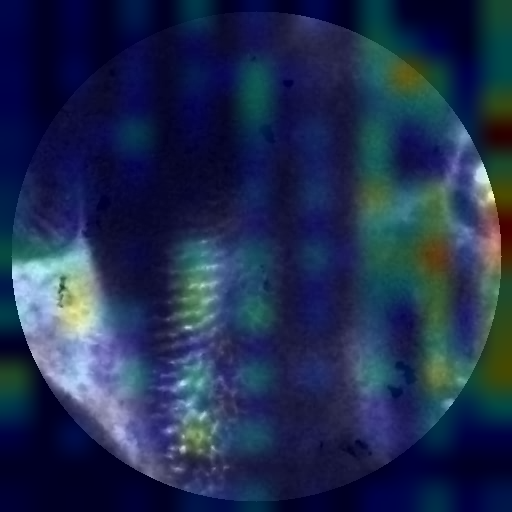

In [24]:
from IPython.display import Image, display
import matplotlib as mpl

def save_and_display_gradcam(img_path, heatmap, cam_path="/home/abidhasan/Documents/Indicate_FH/sample_image/mobilenet_affedted_cam.png", alpha=0.4):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)
    print("Image shape {}".format(img.shape))
    print("Image Max Pixel value: {}".format(np.max(img)))

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    print('Shape of Jet_heatmap: {}'.format(jet_heatmap.shape))
    print("Jet Heatmap Max Pixel value: {}".format(np.max(jet_heatmap)))

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(affected_img1, heatmap)